## Exploratory plots: temporal/spatial density, avg depth profiles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs, feature
from matplotlib.gridspec import GridSpec
import cmocean as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),density (kg m-3),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754136,1754136,1841132,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,1024.310554,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,484.541716,NaN
1754137,1754137,1841133,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,1024.310730,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,484.541716,NaN
1754138,1754138,1841134,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,1024.962773,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,215.824564,-0.0
1754139,1754139,1841135,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,1024.296804,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,215.824564,-0.0


In [3]:
pd.unique(obs['current'])

array(['shelf', nan, 'CUC', 'CC'], dtype=object)

In [4]:
obs['time'] = pd.to_datetime(obs.time)

In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

## Plots to understand temporal and spatial resolution

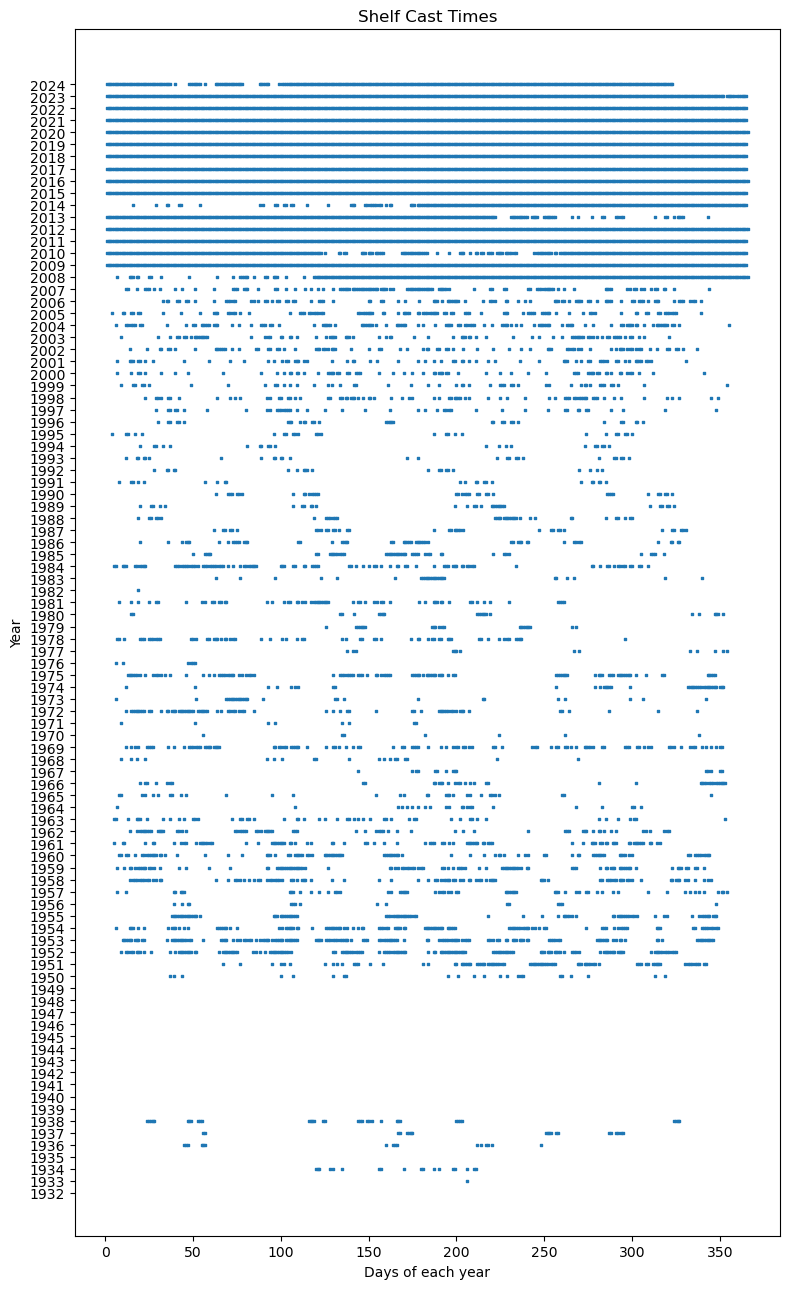

In [6]:
# Temporal resolution of Shelf Current
fig, ax = plt.subplots(figsize=(8, 13))

obs_shelf_dd = obs_shelf.drop_duplicates(subset='time', keep='first')

obs_shelf_dd['time'] = pd.to_datetime(obs_shelf_dd['time'])

yearDay = obs_shelf_dd['time'].dt.dayofyear
year = obs_shelf_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )

ax.set_title('Shelf Cast Times')
ax.set_yticks(range(1932, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')

plt.tight_layout()
plt.show()

# Group by year and source, then count rows
grouped = obs_shelf.groupby(['year', 'source']).size().reset_index(name='count')

# Print results year by year
# with open(OUTPATH+'/'+"ShelfCurrent_YearSource.txt", "w") as file:
#     for year in sorted(grouped['year'].unique()):
#         file.write(f"\n\nIn {year} there is:")
#         sub = grouped[grouped['year'] == year]
#         for _, row in sub.iterrows():
#             file.write(f"\n    {row['source']}: {row['count']}")

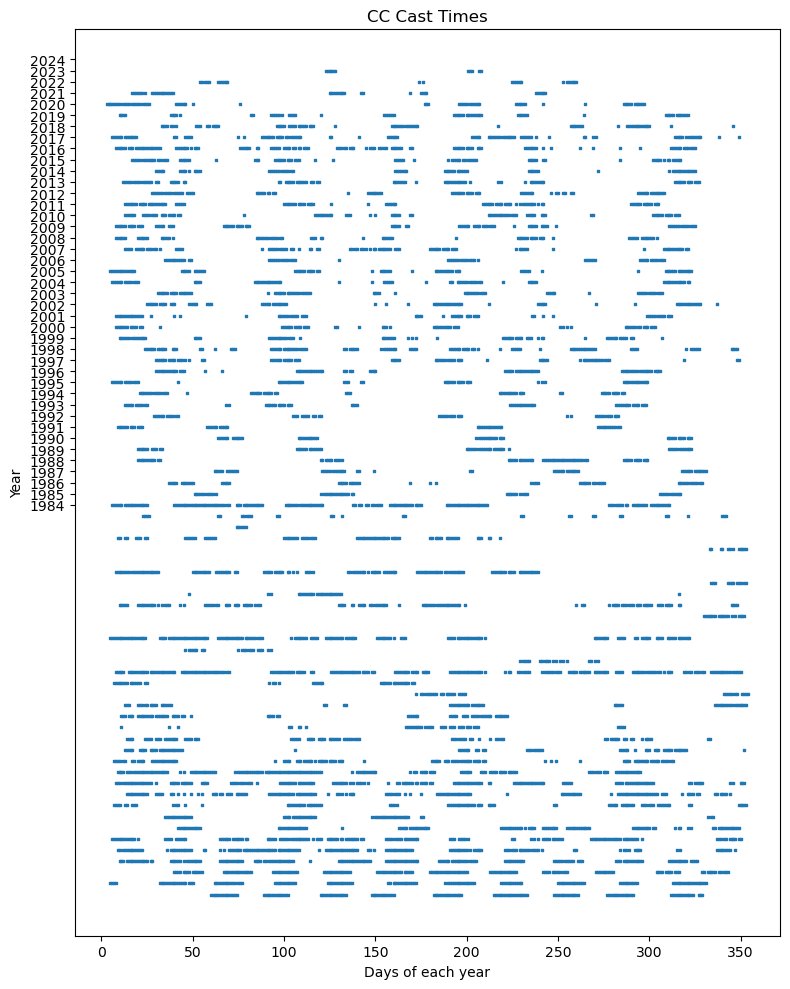

In [7]:
# Temporal resolution of California Current
fig, ax = plt.subplots(figsize=(8, 10))

obs_cc_dd = obs_cc.drop_duplicates(subset='time', keep='first')

obs_cc_dd['time'] = pd.to_datetime(obs_cc_dd['time'])

yearDay = obs_cc_dd['time'].dt.dayofyear
year = obs_cc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CC Cast Times')
ax.set_yticks(range(1984, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

# Print results year by year
# with open(OUTPATH+'/'+"CC_YearSource.txt", "w") as file:
#     for year in sorted(grouped['year'].unique()):
#         file.write(f"\n\nIn {year} there is:")
#         sub = grouped[grouped['year'] == year]
#         for _, row in sub.iterrows():
#             file.write(f"\n    {row['source']}: {row['count']}")

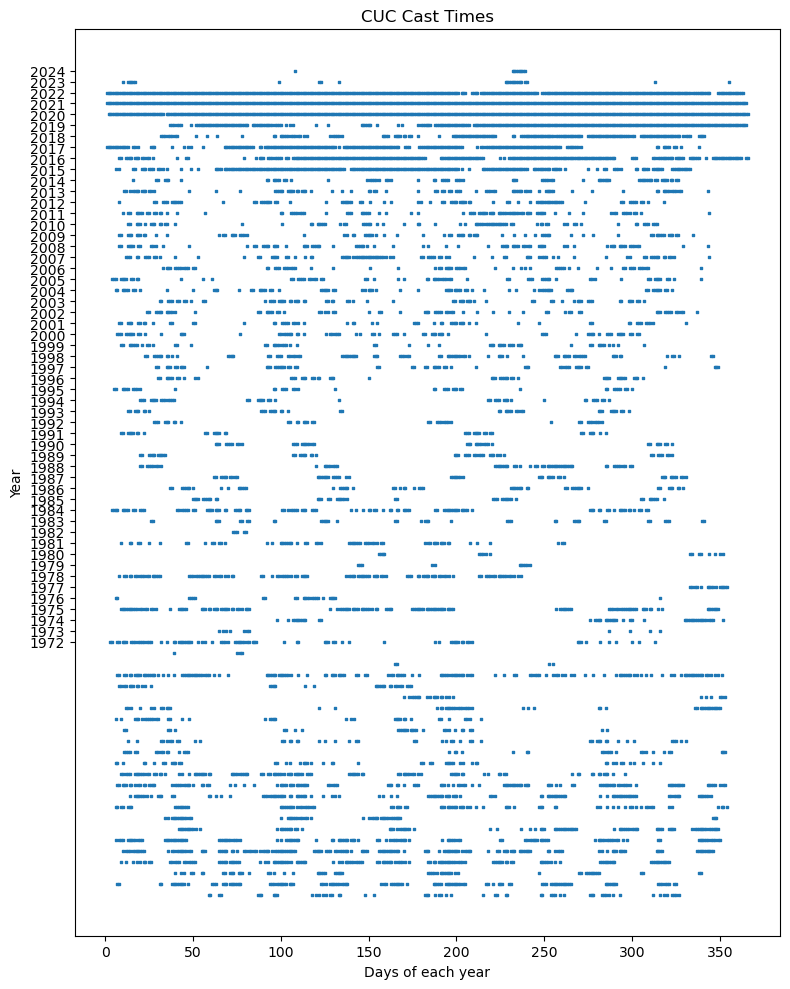

In [8]:
# Temporal resolution of California Under Current
fig, ax = plt.subplots(figsize=(8, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

obs_cuc_dd['time'] = pd.to_datetime(obs_cuc_dd['time'])

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

# Print results year by year
# with open(OUTPATH+'/'+"CUC_YearSource.txt", "w") as file:
#     for year in sorted(grouped['year'].unique()):
#         file.write(f"\n\nIn {year} there is:")
#         sub = grouped[grouped['year'] == year]
#         for _, row in sub.iterrows():
#             file.write(f"\n    {row['source']}: {row['count']}")

Text(0.5, 1.0, 'Shelf Current Data Density')

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

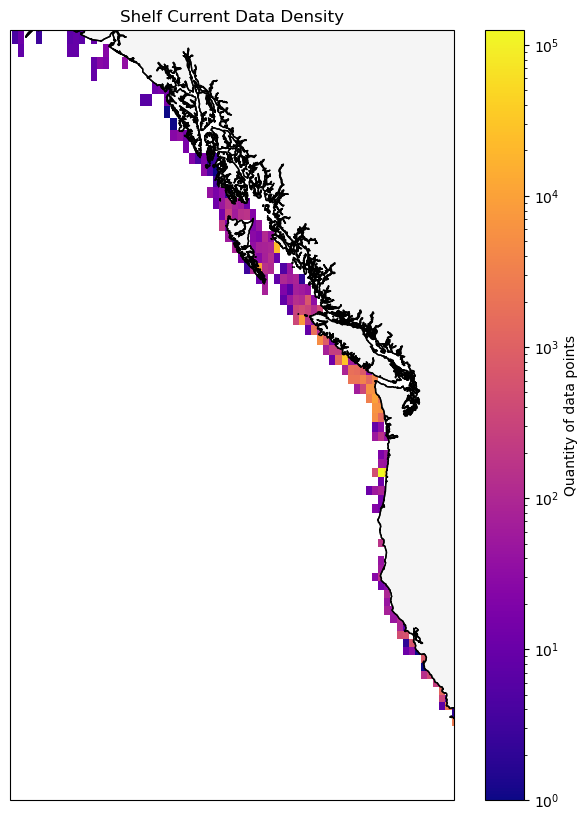

In [9]:
# Shelf Current Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare your data
lon = obs_shelf['longitude (degrees_east)']
lat = obs_shelf['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=100)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('Shelf Current Data Density')

Text(0.5, 1.0, 'California Current Data Density')

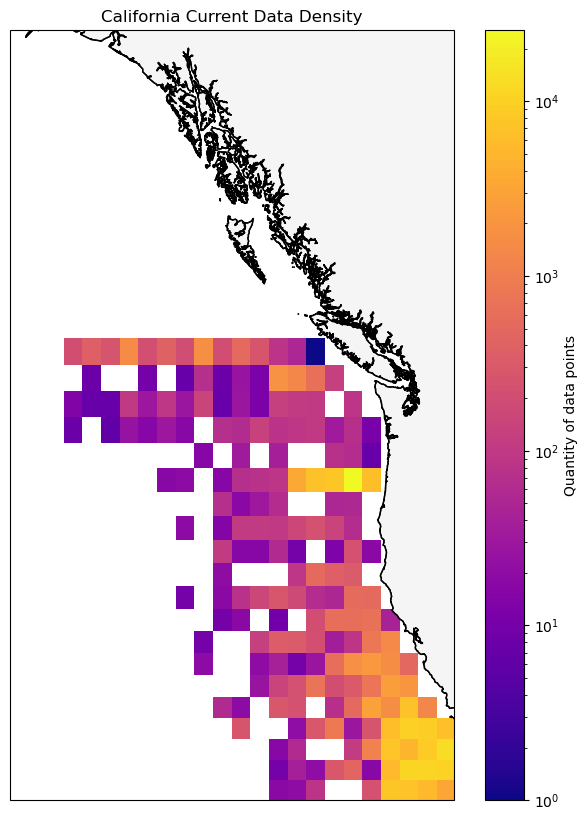

In [10]:
# CC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs_cc['longitude (degrees_east)']
lat = obs_cc['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=30)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Current Data Density')

Text(0.5, 1.0, 'California Undercurrent Data Density')

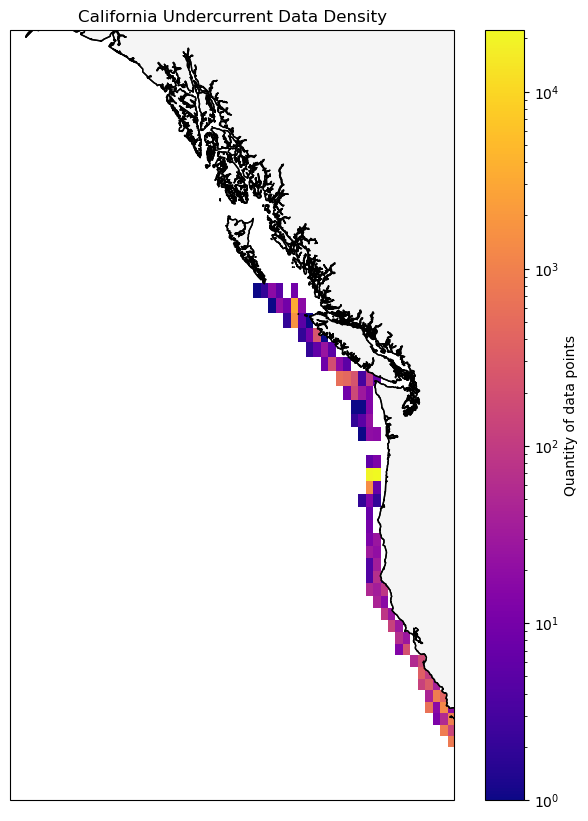

In [11]:
# CUC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs_cuc['longitude (degrees_east)']
lat = obs_cuc['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=50)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Undercurrent Data Density')

In [12]:
distance_line = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/distances.csv')
distance_line

def map_line(df, ax,ticklabels=True, lw=2,mark='o'):
    lats_NS, lons_NS, d_NS = df.latNS, df.lonNS, df.distNS
    lats_EW, lons_EW, d_EW = df.latEW, df.lonEW, df.distEW

    ax.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='k', lw=lw,zorder=4)
    ax.plot(lons_EW, lats_EW, '--', transform=crs.PlateCarree(), color='k', lw=lw,zorder=4)

    # — place tick-marks every ±1000 km —
    ticks = [-1000, -500, 0, 500,1000, 1500,2000]
    for t in ticks:
        # Draw tick on NS leg if in range
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.plot([lon_t], [lat_t], marker=mark, markersize=4,
                    transform=crs.PlateCarree(), color='k')

        # Draw tick on EW leg if in range
        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.plot([lon_t], [lat_t], marker=mark, markersize=4,
                    transform=crs.PlateCarree(), color='k')
            
    if ticklabels == True:
        for t in ticks[1::2]:
            if d_NS.min() <= t <= d_NS.max():
                idx = np.argmin(np.abs(d_NS - t))
                lon_t, lat_t = lons_NS[idx], lats_NS[idx]
                ax.text(lon_t-0.5, lat_t, f"{int(t):+d}",
                        transform=crs.PlateCarree(),
                        va='bottom', ha='right', fontsize=8, zorder=6)

            if d_EW.min() <= t <= d_EW.max():
                idx = np.argmin(np.abs(d_EW - t))
                lon_t, lat_t = lons_EW[idx], lats_EW[idx]
                ax.text(lon_t, lat_t+0.02, f"{int(t):+d}",
                        transform=crs.PlateCarree(),
                        va='bottom', ha='right', fontsize=8, zorder=6)

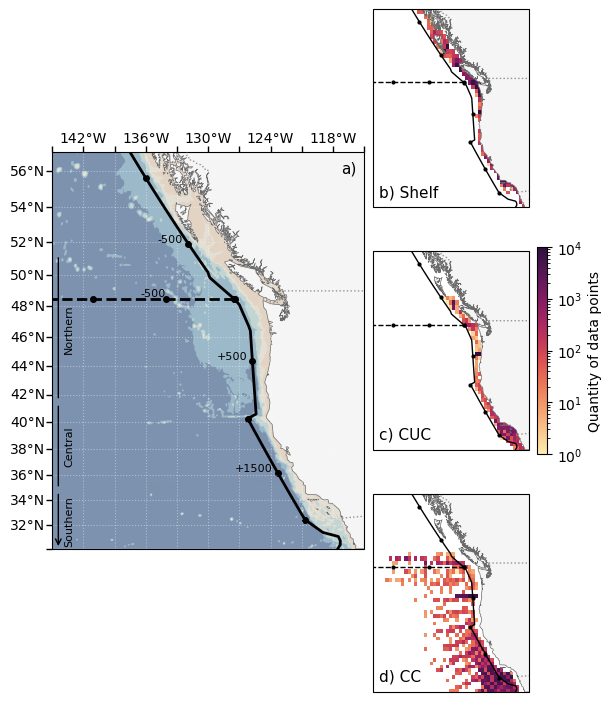

In [14]:
xlim, ylim = [-145, -115], [30, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)

fig = plt.figure(constrained_layout=True, figsize=[6,7])
gs = GridSpec(3, 3, figure=fig)
ax0 = fig.add_subplot(gs[:, :2], projection=proj)
ax2 = fig.add_subplot(gs[0, 2], projection=proj)
ax3 = fig.add_subplot(gs[1, 2], projection=proj)
ax4 = fig.add_subplot(gs[2, 2], projection=proj)

ax0.set_extent(xlim+ylim)
ax2.set_extent(xlim+ylim)
ax3.set_extent(xlim+ylim)
ax4.set_extent(xlim+ylim)

############
# ALL MAPS #
############

for axs in [ax0,ax2,ax3,ax4]:
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

for axs in [ax2,ax3,ax4]:
    # distance line
    map_line(distance_line,axs,ticklabels=False,lw=1,mark='.')
map_line(distance_line,ax0)

# add plot identifiers
ax0.text(.95, 0.98, 'a)', ha='center', va='top', transform=ax0.transAxes, fontsize=11)
ax2.text(.04, 0.04, 'b) Shelf', ha='left', va='bottom', transform=ax2.transAxes, fontsize=11)
ax3.text(.04, 0.04, 'c) CUC', ha='left', va='bottom', transform=ax3.transAxes, fontsize=11)
ax4.text(.04, 0.04, 'd) CC', ha='left', va='bottom', transform=ax4.transAxes, fontsize=11)


############
# MAIN MAP #
############

# Create custom colormap
colors1 = cm.cm.turbid(np.linspace(0, 1, 3))  # First colormap from 0 to 200m
colors2 = cm.cm.ice_r(np.linspace(0, 1, 5))  # Second colormap from 200m to 2000m

# add bathymetry
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_L_0', scale='10m', category='physical',facecolor=colors1[1], edgecolor='none',alpha=0.3,zorder=1))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor=colors2[0], edgecolor='none',alpha=0.3,zorder=1))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor=colors2[1], edgecolor='none',alpha=0.3,zorder=1))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor=colors2[2], edgecolor='none',alpha=0.3,zorder=1))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_H_3000', scale='10m', category='physical',facecolor=colors2[3], edgecolor='none',alpha=0.3,zorder=1))

# Add gridlines
xlocs = np.arange(xlim[0],xlim[-1]+1,3)
ylocs = np.arange(ylim[0],ylim[-1]+1,2)
gl = ax0.gridlines(linestyle=":", color='w', alpha=0.4, draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.right_labels = False
gl.bottom_labels = False

# Manually add ticks at the grid locations
ax0.set_xticks(xlocs, crs=crs.PlateCarree())  
ax0.set_yticks(ylocs, crs=crs.PlateCarree())
ax0.set_xticklabels([],)  
ax0.set_yticklabels([],)
ax0.tick_params(
    axis='x', direction='out', length=4, width=1, color='black', top=True, bottom=False  # Ticks only on top
)
ax0.tick_params(
    axis='y', direction='out', length=4, width=1, color='black', left=True, right=False  # Ticks only on right
)

## CCS SUBREGIONS
# define the section lat‐bounds (°N)
sections = {
    'Southern': (30, 33.9),
    'Central':  (34.1, 39.9),
    'Northern': (40.1, 50),
}

style = ['->','-','-']
i=0
for name, (lat0, lat1) in sections.items():
    # convert data‐space lat to axes‐fraction [0,1]
    f0 = (lat0 - ylim[0]) / (ylim[1] - ylim[0])
    f1 = (lat1 - ylim[0]) / (ylim[1] - ylim[0])

    # draw the bracket line
    ax0.annotate(
        '', 
        xy=(0.02, f0), 
        xytext=(0.02, f1), 
        xycoords='axes fraction',
        arrowprops=dict(
            arrowstyle=style[i],    # bracket style
            lw=1,               # line width
            color='k',
        )
    )
    i+=1

    # place the text just to the left of the bracket
    ax0.text(
        0.07, 
        0.5*(f0+f1), 
        name,
        transform=ax0.transAxes,
        va='center',
        ha='right',
        fontsize=8,
        rotation='vertical',
    )


############################
# Observation Distribution #
############################

# keep things consistent between currents
xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

# SHELF
lon = obs_shelf['longitude (degrees_east)']
lat = obs_shelf['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax2.pcolormesh(X, Y, hist.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax, label="Quantity of data points")

#######
# CUC #
#######
lon = obs_cuc['longitude (degrees_east)']
lat = obs_cuc['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax3.pcolormesh(X, Y, hist.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax3, location='right',orientation='vertical',label="Quantity of data points")

######
# CC #
######
lon = obs_cc['longitude (degrees_east)']
lat = obs_cc['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax4.pcolormesh(X, Y, hist.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax, label="Quantity of data points")

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/datamap.pdf')

## seasonal biases at different latitudes

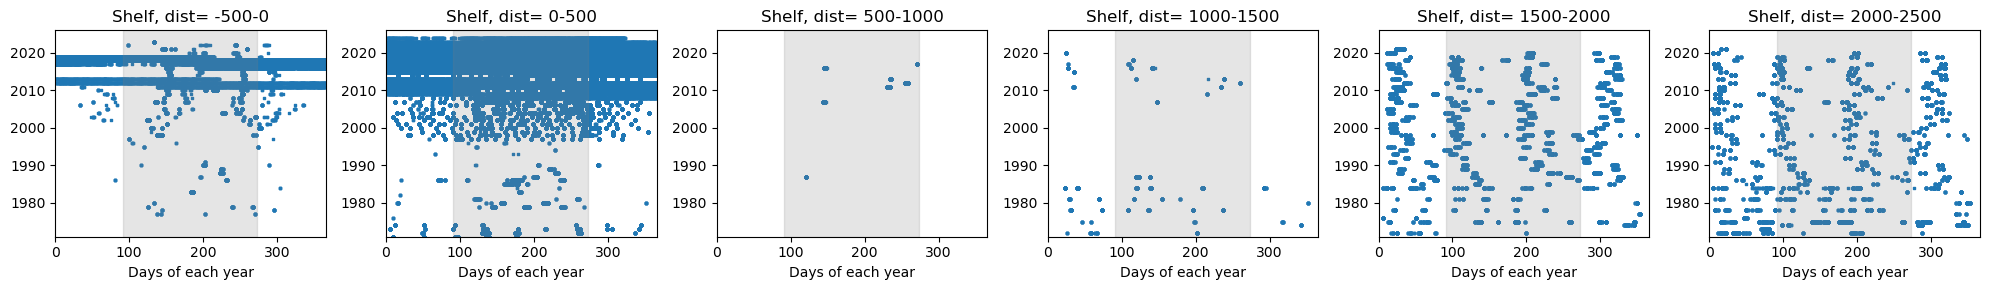

In [14]:
# Temporal resolution of shelf
obs_used = obs_shelf
yearDay = obs_used['time'].dt.dayofyear
year = obs_used['year']

dbins = np.arange(-500,2501,500)
fig, ax = plt.subplots(1,len(dbins)-1,figsize=[20,3])

for i in range(len(dbins)-1):
    idx = (obs_used.dist>=dbins[i])&(obs_used.dist<dbins[i+1])
    if sum(idx)==0:
        continue

    ax[i].scatter(yearDay[idx], year[idx], s=2, marker='s' )
    ax[i].fill_between(np.arange(1,366,1),1971,2026,where=(np.arange(1,366,1)>90)&(np.arange(1,366,1)<=273),color='grey',alpha=0.2) # april to end of september?


    ax[i].set_title('Shelf, dist= {}-{}'.format(dbins[i],dbins[i+1]))
    # ax[i].set_yticks(range(1972, 2025)) 
    ax[i].set_ylim([1971,2026]) 
    ax[i].set_xlim([0,366])
    # ax[i].set_ylabel('Year')
    ax[i].set_xlabel('Days of each year')


plt.tight_layout()

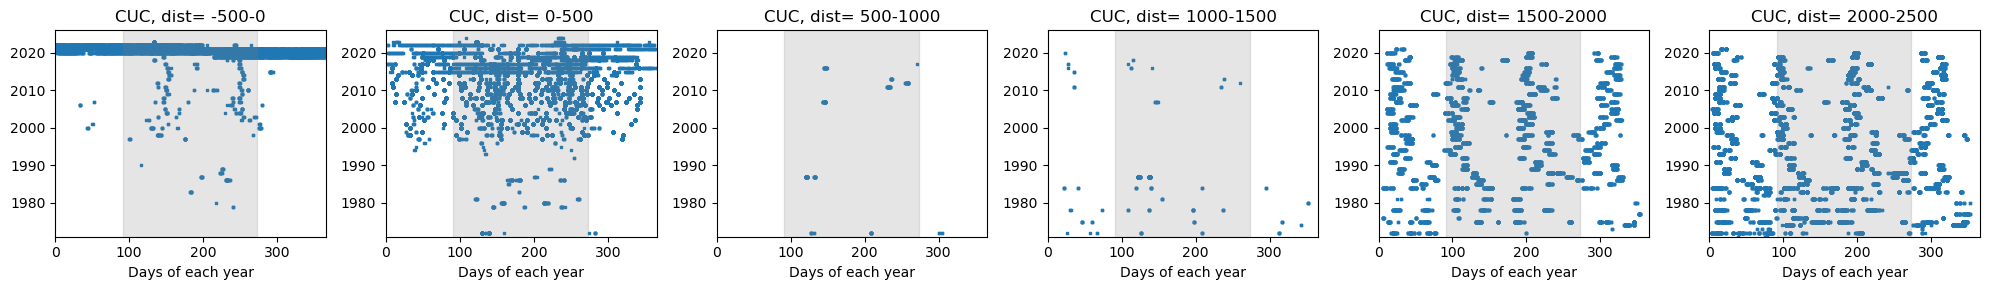

In [15]:
# Temporal resolution of California Under Current
obs_used = obs_cuc
yearDay = obs_used['time'].dt.dayofyear
year = obs_used['year']

dbins = np.arange(-500,2501,500)
fig, ax = plt.subplots(1,len(dbins)-1,figsize=[20,3])

for i in range(len(dbins)-1):
    idx = (obs_used.dist>=dbins[i])&(obs_used.dist<dbins[i+1])
    if sum(idx)==0:
        continue

    ax[i].scatter(yearDay[idx], year[idx], s=2, marker='s' )
    ax[i].fill_between(np.arange(1,366,1),1971,2026,where=(np.arange(1,366,1)>90)&(np.arange(1,366,1)<=273),color='grey',alpha=0.2)


    ax[i].set_title('CUC, dist= {}-{}'.format(dbins[i],dbins[i+1]))
    # ax[i].set_yticks(range(1972, 2025)) 
    ax[i].set_ylim([1971,2026]) 
    ax[i].set_xlim([0,366])
    # ax[i].set_ylabel('Year')
    ax[i].set_xlabel('Days of each year')


plt.tight_layout()

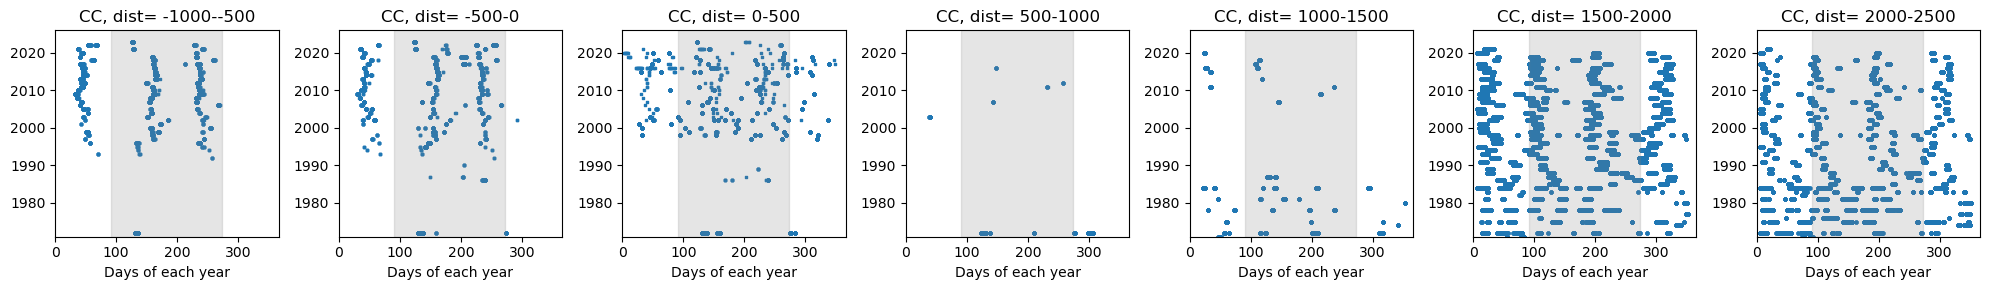

In [16]:
# Temporal resolution of California Under Current
obs_used = obs_cc
yearDay = obs_used['time'].dt.dayofyear
year = obs_used['year']

dbins = np.arange(-1000,2501,500)
fig, ax = plt.subplots(1,len(dbins)-1,figsize=[20,3])

for i in range(len(dbins)-1):
    idx = (obs_used.dist>=dbins[i])&(obs_used.dist<dbins[i+1])
    if sum(idx)==0:
        continue

    ax[i].scatter(yearDay[idx], year[idx], s=2, marker='s' )
    ax[i].fill_between(np.arange(1,366,1),1971,2026,where=(np.arange(1,366,1)>90)&(np.arange(1,366,1)<=273),color='grey',alpha=0.2)


    ax[i].set_title('CC, dist= {}-{}'.format(dbins[i],dbins[i+1]))
    # ax[i].set_yticks(range(1972, 2025)) 
    ax[i].set_ylim([1971,2026]) 
    ax[i].set_xlim([0,366])
    # ax[i].set_ylabel('Year')
    ax[i].set_xlabel('Days of each year')


plt.tight_layout()

## Average Temp Depth Profiles

In [17]:
def avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str):
    """
    Takes a dataframe of observations and specifies a variable to look at, then depth bins avgs at 4 times in a year
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    depth_ranges :
        numpy array of depth ranges ex [0, 20, 40, ..., 180, 200]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    profile_avg
        avg profiles at 4 seasons
    """
    profile_avg = np.empty((4, len(depth_ranges)-1))
    for n in range(4):
        if n == 0:
            start_mon, end_mon = 1, 3
        elif n == 1:
            start_mon, end_mon = 4, 6
        elif n == 2:
            start_mon, end_mon = 7, 9
        elif n == 3:
            start_mon, end_mon = 10, 12
            
        for i in range(len(depth_ranges)-1):
            dep_mask = ((obs_used['depth (m)'] >= depth_ranges[i]) & (obs_used['depth (m)'] <= depth_ranges[i+1]) & 
                        (obs_used['month'] >= start_mon) & (obs_used['month'] <= end_mon))
            profile_avg[n,i] = np.mean(obs_used[dep_mask][variable_str])
    profile_avg =  np.array(profile_avg)
    return profile_avg

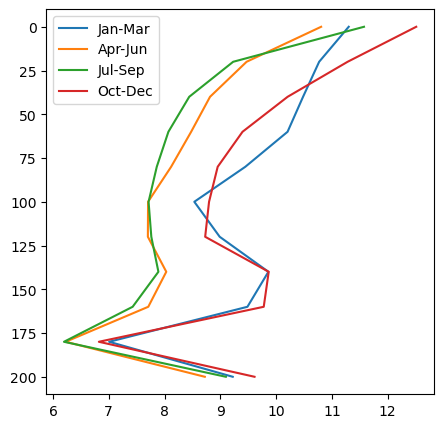

In [18]:
# Shelf Current Avg Temp Profiles
obs_used = obs_shelf

depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))

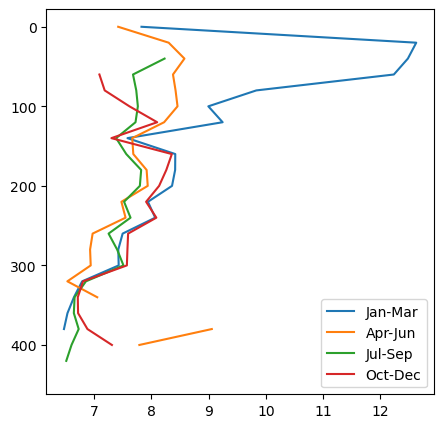

In [19]:
# California Undercurrent Avg Temp Profiles
obs_used = obs_cuc

depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))

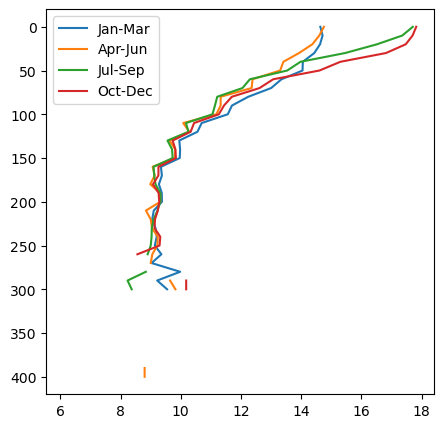

In [20]:
# California Current Avg Temp Profiles
obs_used = obs_cc

depth_ranges = np.arange(0,500,10) # Every 10m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))